In [1]:
%matplotlib notebook

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 4.0)

import load_hats

start_day, end_day = '2016-06-01', '2018-05-31'
site = 'spo'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met(site, y)
    dfs.append(df)
    
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-06-01 00:00:00,SPO,2.0,8.1,100,668.06
2016-06-01 01:00:00,SPO,1.0,8.1,100,668.17
2016-06-01 02:00:00,SPO,3.0,7.5,100,668.26
2016-06-01 03:00:00,SPO,358.0,7.9,100,668.23
2016-06-01 04:00:00,SPO,3.0,7.2,100,668.46


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
insitu = cats.hourly('f11', site)
insitu = insitu[start_day:end_day].dropna()
insitu.head()

,spo_mr,spo_sd
date,,
2016-06-01 00:31:00,227.900,0.255
2016-06-01 01:32:00,227.254,0.255
2016-06-01 02:32:00,227.718,0.254
2016-06-01 03:32:00,227.978,0.254
2016-06-01 04:32:00,227.415,0.254


<h2>Merge dataframes and interpolate wind speed and direction

In [6]:
full = pd.concat([insitu, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,spo_mr,spo_sd,wind_dir,wind_speed
date,,,,
2016-06-01 00:31:00,227.900,0.255,1.5,8.10
2016-06-01 01:32:00,227.254,0.255,2.0,7.80
2016-06-01 02:32:00,227.718,0.254,180.5,7.70
2016-06-01 03:32:00,227.978,0.254,180.5,7.55
2016-06-01 04:32:00,227.415,0.254,5.5,6.85


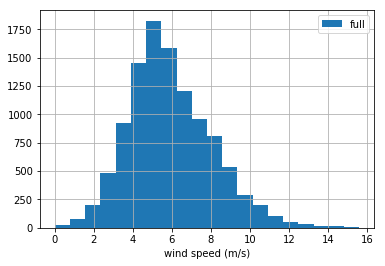

In [7]:
full.wind_speed.hist(bins=20, label='full')
plt.xlabel('wind speed (m/s)')
plt.legend()

<h3>Remove low wind speeds less than 3 m/s

In [8]:
clean = full.loc[full.wind_speed>3]

Text(0, 0.5, 'CFC-11 (ppt)')

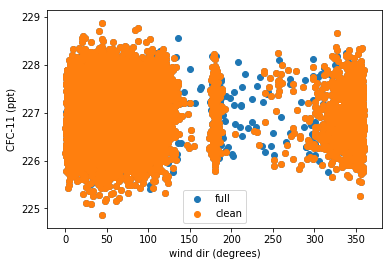

In [9]:
plt.scatter(full.wind_dir, full.spo_mr, label='full')
plt.scatter(clean.wind_dir, clean.spo_mr, label='clean')
plt.legend()
plt.xlabel('wind dir (degrees)')
plt.ylabel('CFC-11 (ppt)')

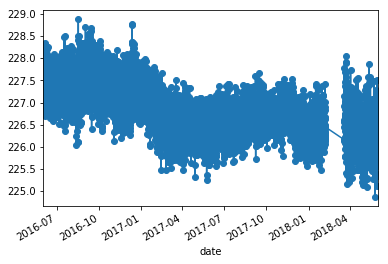

In [10]:
clean.spo_mr.plot(marker='o')

<h2>Subsample to once a day at 12-14 GMT    

In [11]:
clean.head()

,spo_mr,spo_sd,wind_dir,wind_speed
date,,,,
2016-06-01 00:31:00,227.900,0.255,1.5,8.10
2016-06-01 01:32:00,227.254,0.255,2.0,7.80
2016-06-01 02:32:00,227.718,0.254,180.5,7.70
2016-06-01 03:32:00,227.978,0.254,180.5,7.55
2016-06-01 04:32:00,227.415,0.254,5.5,6.85


In [13]:
clean = full.loc[full.wind_speed>3]
clean.reset_index(inplace=True)
# select hours
clean = clean.assign(hh=(clean.date.dt.hour==12)|(clean.date.dt.hour==13))
clean = clean.loc[clean.hh==True].drop(['hh'], axis=1)
# if two data points, select the first
clean = clean.assign(dd=clean.date.diff()>datetime.timedelta(0,4000))
clean = clean.loc[clean.dd==True].drop(['dd'], axis=1)
clean.set_index(clean.date, inplace=True)
clean.drop(['date'], axis=1, inplace=True)

In [14]:
clean.head()

,spo_mr,spo_sd,wind_dir,wind_speed
date,,,,
2016-06-03 12:46:00,227.455,0.302,325.0,5.70
2016-06-04 12:52:00,228.337,0.285,354.0,9.85
2016-06-05 12:58:00,227.491,0.283,184.0,6.30
2016-06-06 12:04:00,227.550,0.243,115.0,4.90
2016-06-07 12:10:00,227.660,0.194,70.5,3.75


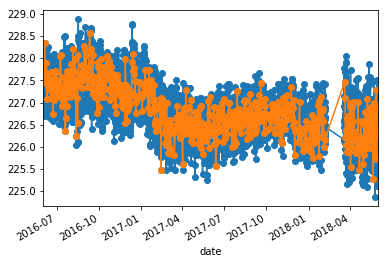

In [15]:
full.spo_mr.plot(marker='o')
clean.spo_mr.plot(marker='o')

In [16]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:10831 clean:584
